TODO:
redo mfold for these with actual gtex alleles. check cstb lengths
add DPYSL4 - long alleles cutoff
alox5 - why multiples of 6 not 3 for expression plot

for r2: allele lengths got cut off at 50

# Part 3: CG-rich promoter eSTRs form transcription-inducing DNA secondary structures

#### Figures:
* **Figure 3A**: Schematic of G4 repeats at promoters (not in notebook)
* **Figure 3B**: G4 motifs direction of effect
* **Figure 3C**: G4 overall free energy
* **Figure 3D**: G4 change in energy
* **Figure 3E**: G4 r
* **Figure 3F**: G4 two examples (CSTB and multi-allelic)

TODO: overlap with pol 2 pausing?

#### Supplementary Figures:

#### Supplementary Tables:

#### Statistics:


In [1]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-G4"
FIGPREFIX = "Figure3"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
estrs = pd.read_csv(os.path.join(BASERESULTSDIR, "eSTR-calling","SuppTable_ALLCAUSAL.csv"))
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand"]], on=["gene"])

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

mfold = pd.read_csv("/storage/mgymrek/gtex/mfold/all_strs_mfold_summary.tab", sep="\t", \
                    names=["chrom","str.start","str.end","type","strand", "mfold_r", "mfold_mean", "mfold_min","mfold_max"])
mfold["chrom"] = mfold["chrom"].apply(lambda x: "chr"+str(x))
mfold["str.start"] = mfold["str.start"]+1
mfold = mfold.drop_duplicates()
hipref = pd.read_csv(HIPREF, sep="\t", names=["chrom","str.start","str.end","motif"], usecols=[0,1,2,4])
hipref["str.start"] = hipref["str.start"]+1
mfold = pd.merge(hipref, mfold, on=["chrom","str.start"])

all_mfold = pd.read_csv("/storage/mgymrek/gtex/mfold/all_strs_mfold.tab", sep="\t")
all_mfold = all_mfold.drop_duplicates()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def IsG4(motif):
    g4_motifs = ["AGGG", "CCCG",\
                "ACCC", "GGGT", \
                "AGGGG", "CCCCT", \
                "C", "G", \
                "ACCC", "GGGT", \
                "CCCG", "CGGG", \
                "CCCCG", "CGGGG", \
                 "ACCCC", "GGGGT", \
                "AAGGG", "CCCTT", \
                "AGCCC", "GGGCT", \
                "AGGGC", "GCCCT", \
                "ACCCCC", "GGGGGT", \
                "AGCCCC", "GGGGCT", \
                "CCCCCG", "CGGGGG", \
                "CCCGG", "CCGGG", \
                "AGAGGG", "CCCTCT"]
    return motif in g4_motifs

# Figure 3B: Effect size direction

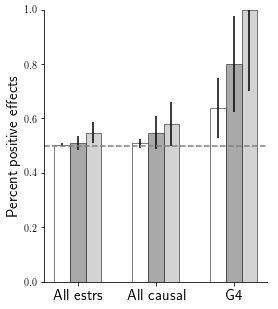

In [3]:
# Get direction+stderr for:
# G4 causal all, G4 causal promoter
# all causal, all promoter
# http://www.pmean.com/01/zeroevents.html for estimating conf interval when no events

labels = []
colors = []
ecolors = []
dirs = []
stderrs = []
nums = []
xvals = []
pvals = []

w = 0.2
dist = 3000
tss_bins = [(-1000000, 10000000), (-1*dist, dist), (0, dist)]
binlabels = ["ALL", "promoter", "downstream"]
bincolors = [ "white", "darkgray", "lightgray"]

g4 = causal[causal["motif"].apply(IsG4)]
dfs = [ estrs, causal, g4]
dflabels = ["All estrs", "All causal", "G4"]
#for period in range(1, 7):
#    dfs.append(causal[causal["motif"].apply(len)==period])
#    dflabels.extend(["%s"%period])

ind = 0
for df in dfs:
    dflabel = dflabels[ind]
    for tbin in tss_bins:
        l = binlabels[tss_bins.index(tbin)]
        df_bin = df[(df["dist.tss"]>=tbin[0]) & (df["dist.tss"]<tbin[1])]
        perc = np.mean(df_bin["beta"]>0)
        dirs.append(perc)
        if perc < 1:
            stderrs.append(1.96*np.sqrt(perc*(1-perc)/df_bin.shape[0]))
        else:
            stderrs.append(3/df_bin.shape[0])
        nums.append(df_bin.shape[0])
        pvals.append(scipy.stats.binom_test(perc*df_bin.shape[0], df_bin.shape[0]))
    ind += 1
    colors.extend(bincolors)
    ecolors.extend(bincolors)
    xvals.extend([ind, ind+w, ind+2*w])
    labels.append(dflabel)
    
fig = plt.figure()
fig.set_size_inches((4, 5))
ax = fig.add_subplot(111)
ax.bar(xvals, dirs, color=colors, edgecolor="black", linewidth=0.5, yerr=stderrs, ecolor="black", width=w)
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_ylim(bottom=0, top=1);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([xvals[i] for i in range(len(xvals)) if i%3 == 1])
ax.set_xticklabels(labels, size=15);
ax.set_ylabel("Percent positive effects", size=15)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_G4Direction.pdf"%FIGPREFIX));

In [4]:
print(nums[6:9])
print(dirs[6:9])
print(pvals[6:9])

print(nums[3:6])
print(dirs[3:6])
print(pvals[3:6])

[72, 20, 10]
[0.6388888888888888, 0.8, 1.0]
[0.02446090732832436, 0.011817932128906248, 0.001953125]
[3474, 258, 140]
[0.5086355785837651, 0.5465116279069767, 0.5785714285714286]
[0.33350752887740354, 0.1520286512519002, 0.07555082875265655]


# Figure 3C/D Free energy


mfold mean
estr vs. causal
Ks_2sampResult(statistic=0.020636481074206375, pvalue=0.14676794479792632)
g4 estr vs. all
Ks_2sampResult(statistic=0.29824444731537564, pvalue=2.5851896915074082e-31)
g4 causal vs. all
Ks_2sampResult(statistic=0.38557285659361784, pvalue=7.976095008614424e-10)

mfold diff
estr vs. causal
Ks_2sampResult(statistic=0.02402152234027044, pvalue=0.05809992790465379)
g4 estr vs. all
Ks_2sampResult(statistic=0.40660036641210023, pvalue=7.779486679742684e-58)
g4 causal vs. all
Ks_2sampResult(statistic=0.44925028835063435, pvalue=3.47422105177702e-13)

mfold r
estr vs. causal
Ks_2sampResult(statistic=0.05499765457830508, pvalue=5.653279999594367e-05)
g4 estr vs. all
Ks_2sampResult(statistic=0.25524972517277356, pvalue=1.6111980155987834e-19)
g4 causal vs. all
Ks_2sampResult(statistic=0.2842024086896596, pvalue=8.650725356510678e-05)


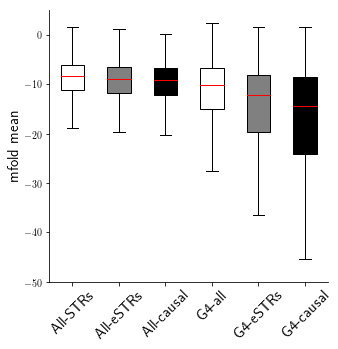

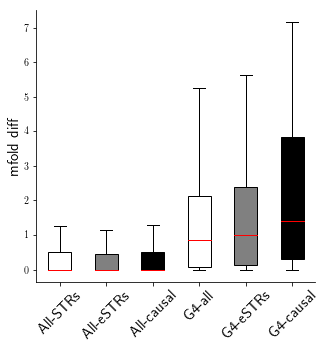

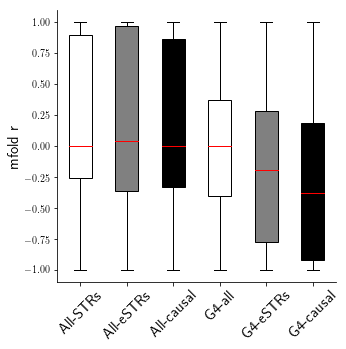

In [5]:
mfold["mfold_diff"] = mfold["mfold_max"]-mfold["mfold_min"]
mfold["mfold_r.dir"] = (mfold["mfold_r"]>0).apply(int)

mfold_e = pd.merge(estrs, mfold[["chrom","str.start","mfold_diff","mfold_r.dir","mfold_r","mfold_mean","type","strand"]], on=["chrom","str.start"])
mfold_e_f = mfold_e[(mfold_e["type"]=="DNA") & (mfold_e["strand"]==mfold_e["gene.strand"])]
mfold_e_r = mfold_e[(mfold_e["type"]=="DNA") & (mfold_e["strand"]!=mfold_e["gene.strand"])]

def GetMin(ll):
    minval = np.inf
    for l in ll:
        if min(l)<minval: minval = min(l)
    return minval

def GetMax(ll):
    maxval = -1*np.inf
    for l in ll:
        if max(l)>maxval: maxval = max(l)
    return maxval

def PlotEnergy(mfold_e_f, mfold_e_r, mfold, col="mfold_mean", fname=None):
    mfold_e_f = mfold_e_f[~np.isnan(mfold_e_f[col])]
    mfold_e_r = mfold_e_r[~np.isnan(mfold_e_r[col])]
    mfold = mfold[~np.isnan(mfold[col])]
    avals = list(mfold[(mfold["strand"]=="+") & (mfold["type"]=="DNA")][col])
    evals = list(mfold_e_f[col])
    #evals2 = list(mfold_e_r[col])
    cvals = list(mfold_e_f[mfold_e_f["causal"]][col])
    #cvals2 = list(mfold_e_r[mfold_e_r["causal"]][col])

    data = [avals, evals, cvals]
    g4_all = mfold[mfold["motif"].apply(IsG4) & (mfold["type"]=="DNA")]
    g4_f = mfold_e_f[mfold_e_f["motif"].apply(IsG4)]
    #g4_r = mfold_e_r[mfold_e_r["motif"].apply(IsG4)]

    data.append(list(g4_all[col]))
    data.append(list(g4_f[col]))
    #data.append(list(g4_r[col]))
    data.append(list(g4_f[g4_f["causal"]][col]))
    #data.append(list(g4_r[g4_r["causal"]][col]))

    print("estr vs. causal")
    print(scipy.stats.ks_2samp(data[1], data[2]))
    print("g4 estr vs. all")
    print(scipy.stats.ks_2samp(data[1], data[4]))
    print("g4 causal vs. all")
    print(scipy.stats.ks_2samp(data[2], data[5]))
    fig = plt.figure()
    fig.set_size_inches((5, 5))
    ax = fig.add_subplot(111)
    bplot = ax.boxplot(data, sym="", patch_artist=True, medianprops={"color": "red"})
    colors = ["white","gray","black","white","gray","black"]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    if col == "mfold_mean":
        ax.set_ylim(bottom=-50, top=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(["All-STRs", "All-eSTRs", "All-causal","G4-all","G4-eSTRs", "G4-causal"], rotation=45, size=15)
    #ax.set_yticklabels([int(item) for item in ax.get_yticks()], size=12)
    ax.set_ylabel(col.replace("_", " "), size=15)
    if fname is not None: fig.savefig(fname)

print("\nmfold mean")
fname = None
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "%s_meanmfold.pdf"%FIGPREFIX)
PlotEnergy(mfold_e_f, mfold_e_r, mfold, col="mfold_mean", fname=fname)

print("\nmfold diff")
fname = None
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "%s_diffmfold.pdf"%FIGPREFIX)
PlotEnergy(mfold_e_f, mfold_e_r, mfold, col="mfold_diff", fname=fname)

print("\nmfold r")
fname = None
if SAVEPLOT: fname = os.path.join(RESULTSDIR, "%s_rmfold.pdf"%FIGPREFIX)
PlotEnergy(mfold_e_f, mfold_e_r, mfold, col="mfold_r", fname=fname)

In [6]:
#mfold_e_f[(mfold_e_f["causal"]) & (mfold_e_f["motif"].apply(IsG4)) & (mfold_e_f["dist.tss"].apply(abs)<5000)][["chrom","gene","gene.name","score","str.start","str.end_x","motif","dist.tss","beta","mfold_r","tissue_info"]]
mfold_e_f[mfold_e_f["gene.name"]=="DPYSL4"]

#causal.columns

,Unnamed: 0,chrom,str.start,str.end,gene,gene.name,dist.tss,motif,score,beta,causal,tissue_info,gene.strand,mfold_diff,mfold_r.dir,mfold_r,mfold_mean,type,strand
1980,3790,chr10,134000825,134000897,ENSG00000151640,DPYSL4,421,CCCGG,0.623273,0.711988,True,Artery-Aorta_0.36_0.00;Esophagus-Mucosa_0.56_0...,+,22.51,0,-0.975169,-45.278182,DNA,+
1982,3789,chr10,133978399,133978423,ENSG00000151640,DPYSL4,-22005,AGCTG,0.000895,-0.513076,False,Thyroid_-0.40_0.00;Muscle-Skeletal_-0.34_0.00;...,+,4.65,0,-0.968218,-23.745000,DNA,+


# Figure 3F: Examples

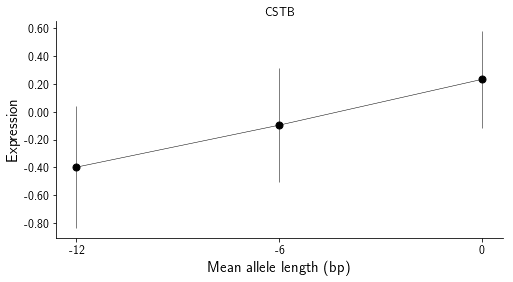

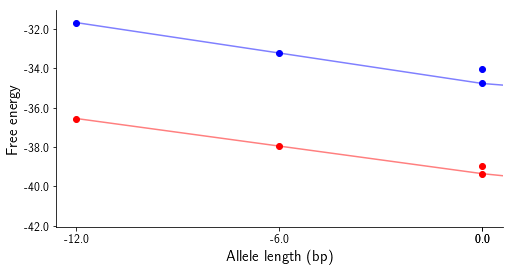

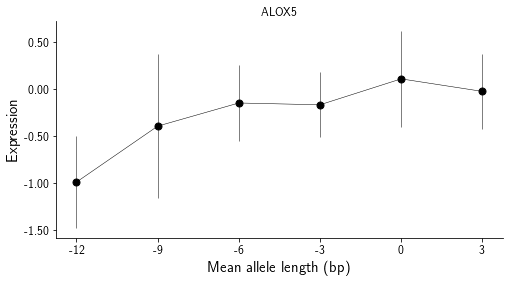

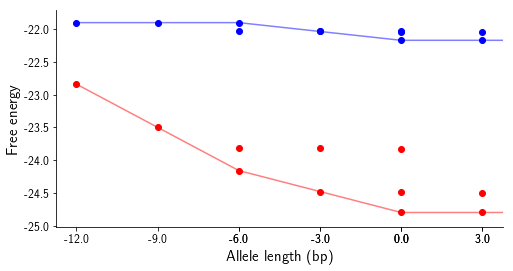

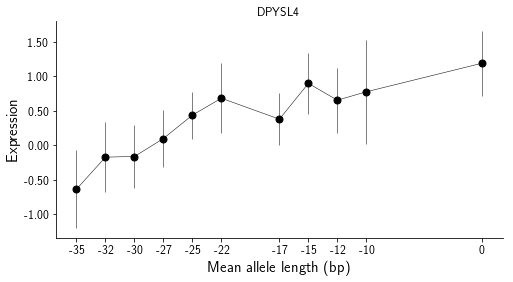

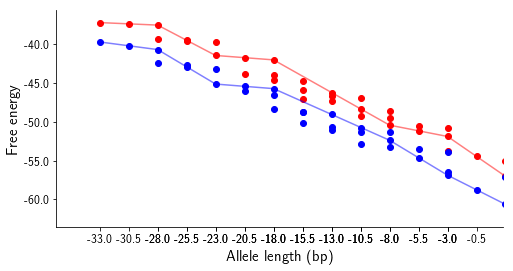

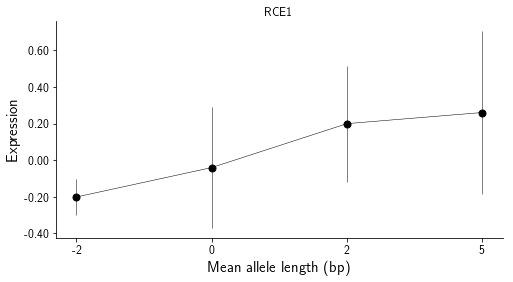

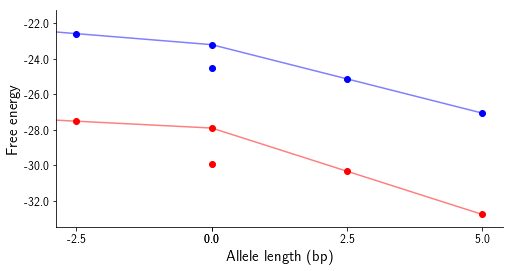

In [7]:
def PlotEnergies(allele_lengths, energies_coding, energies_noncoding, \
                 diploid_lengths, diploid_energies_coding, diploid_energies_noncoding, \
                 reflen=0, xlim=xlim, fname=None):
    allele_lengths = [item-reflen for item in allele_lengths]
    diploid_lengths = [item-reflen for item in diploid_lengths]
        
    fig = plt.figure()
    fig.set_size_inches((8, 4))
    ax = fig.add_subplot(111)
    ax.plot(allele_lengths, energies_coding, color="red", alpha=0.5)
    ax.plot(allele_lengths, energies_noncoding, color="blue", alpha=0.5)
    ax.scatter(diploid_lengths, diploid_energies_coding, color="red")
    ax.scatter(diploid_lengths, diploid_energies_noncoding, color="blue")
    ax.set_xlabel("Allele length (bp)", size=15)
    ax.set_ylabel("Free energy", size=15)
    ax.set_xticks(diploid_lengths)
    ax.set_xticklabels(diploid_lengths, size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.set_xlim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    if fname is not None: fig.savefig(fname)
    
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

def Expand(x):
    buf=0.2
    if x<0: return x-buf
    else: return x+buf

def GetExpr(gene, tissue, chrom, start, end):
    ExtractData(gene, chrom, start, tissue)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr) 
    
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]

    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    sds = data.groupby("str", as_index=False).agg({"expr": np.std})
    sds["sdev"] = sds["expr"]
    means = pd.merge(means, sds[["str","sdev"]], on=["str"])
    return means[["str","expr","sdev"]]
  
def PlotExpr(gene, tissue, chrom, start, end, locus, fname=None):
    esum = GetExpr(gene, tissue, chrom, start, end).sort_values("str")
    esum["str"] = esum["str"]/2.0
    fig = plt.figure()
    fig.set_size_inches((8, 4))
    ax = fig.add_subplot(111)
    (_, caps, _) = ax.errorbar(esum["str"], esum["expr"], yerr=esum["sdev"], color="black", capthick=0.5, marker="o", markersize='7', linewidth=0.5)
    
    ax.set_xlabel("Mean allele length (bp)", size=15)
    ax.set_ylabel("Expression", size=15)
    ax.set_xticks(esum["str"])
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_title(locus)
    if fname is not None: fig.savefig(fname)
    return plt.xlim() #Expand(min(esum["str"])), Expand(max(esum["str"]))
    
def ExtractMfold(all_mfold, chrom, pos):
    locus = "%s_%s-%s"%(chrom, pos, pos)
    m = all_mfold[all_mfold["locus"]==locus]
    m = m.groupby(["length","strand"], as_index=False).agg({"energy": np.mean}).sort_values("length")
    allele_lengths = list(m[m["strand"]=="+"]["length"])
    energies_coding = list(m[m["strand"]=="+"]["energy"])
    energies_noncoding = list(m[m["strand"]=="-"]["energy"])
    diploid_length = []
    diploid_energies_coding = []
    diploid_energies_noncoding = []

    for i in range(len(allele_lengths)):
        for j in range(i, len(allele_lengths)):
            diploid_length.append((allele_lengths[i]+allele_lengths[j])/2.0)
            diploid_energies_coding.append((energies_coding[i]+energies_coding[j])/2)
            diploid_energies_noncoding.append((energies_noncoding[i]+energies_noncoding[j])/2)

    return allele_lengths, energies_coding, energies_noncoding, \
        diploid_length, diploid_energies_coding, diploid_energies_noncoding

example_loci = []
# CSTB
gene="ENSG00000160213.5"
tissue="Muscle-Skeletal"
chrom="chr21"
pos=45196326
end=45196360
example_loci.append(["CSTB", gene, tissue, chrom, pos, end, 42])

# ALOX5
gene="ENSG00000012779.6"
tissue="Esophagus-Mucosa"
chrom="chr10"
pos=45869548
end=45869585
example_loci.append(["ALOX5", gene, tissue, chrom, pos, end, end-pos+1])

# DYPSL4
gene="ENSG00000151640.8"
tissue="Cells-Transformedfibroblasts"
chrom="chr10"
pos=134000825
end=134000897
example_loci.append(["DPYSL4", gene, tissue, chrom, pos, end, end-pos+1])

# RCE1
gene="ENSG00000173653.3"
tissue="Lung"
chrom="chr11"
pos=66610830
end=66610848
example_loci.append(["RCE1", gene, tissue, chrom, pos, end, 20])

for el in example_loci:
    locus, gene, tissue, chrom, pos, end, reflen = el
    if SAVEPLOT:
        efname = os.path.join(RESULTSDIR, "%s_%s_expr.pdf"%(FIGPREFIX, locus))
        mfname = os.path.join(RESULTSDIR, "%s_%s_energy.pdf"%(FIGPREFIX, locus))
    else:
        efname = None
        mfname = None
    allele_lengths, energies_coding, energies_noncoding, diploid_lengths, diploid_energies_coding, diploid_energies_noncoding = \
        ExtractMfold(all_mfold, chrom.replace("chr",""), pos)
    xlim = PlotExpr(gene, tissue, chrom, pos, end, locus, fname=efname)
    PlotEnergies(allele_lengths, energies_coding, energies_noncoding, \
             diploid_lengths, diploid_energies_coding, diploid_energies_noncoding, \
             reflen=reflen, xlim=xlim, fname=mfname)

# Composite plots

In [8]:
all_strs = pd.read_csv("/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv", sep="\t",
                      usecols=[0,1,3])
all_strs["str.start"] = all_strs["str.start"]+1
all_strs = pd.merge(all_strs, hipref, on=["chrom","str.start"])[["chrom","str.start","str.end","gene","motif"]]
geneannot["gene"] = geneannot["gene.id"]
all_strs["id"] = all_strs.apply(lambda x: "%s:%s"%(x["gene"], x["str.start"]), 1)
all_strs["x"] = "x"
all_strs = pd.merge(all_strs, geneannot, on=["gene"])
all_strs["dist.tss"] = all_strs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

In [25]:
# Make peak annotation files
causal["id"] = causal.apply(lambda x: "%s:%s:%.2f"%(x["gene.name"], x["str.start"], x["score"]), 1)
causal["x"] = "x"
estrs["id"] = estrs.apply(lambda x: "%s:%s:%.2f"%(x["gene.name"], x["str.start"], x["score"]), 1)
estrs["x"] = "x"

dist = 5000 # restrict to close to TSS


all_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_strs_tss.bed"
all_strs[(all_strs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(all_outfile, sep="\t", index=False, header=False)

causal_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_causal_estrs_tss.bed"
causal[(causal["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(causal_outfile, sep="\t", index=False, header=False)

estr_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_estrs_tss.bed"
estrs[(estrs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(estr_outfile, sep="\t", index=False, header=False)

estr_g4_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_estrs_g4.bed"
estrs[estrs["motif"].apply(IsG4) & (estrs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(estr_g4_outfile, sep="\t", index=False, header=False)

causal_g4_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_causal_g4.bed"
causal[causal["motif"].apply(IsG4) & (causal["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(causal_g4_outfile, sep="\t", index=False, header=False)

all_g4_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_strs_g4.bed"
all_strs[all_strs["motif"].apply(IsG4) & (all_strs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(all_g4_outfile, sep="\t", index=False, header=False)


for period in range(1, 7):
    all_mono_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_strs_%s.bed"%period
    all_strs[(all_strs["motif"].apply(len)==period)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(all_mono_outfile, sep="\t", index=False, header=False)
    causal_mono_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_causal_%s.bed"%period
    causal[(causal["motif"].apply(len)==period)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(causal_mono_outfile, sep="\t", index=False, header=False)
    estr_mono_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_estr_%s.bed"%period
    estrs[(estrs["motif"].apply(len)==period)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(estr_mono_outfile, sep="\t", index=False, header=False)
all_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_strs.bed"
all_strs[["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(all_outfile, sep="\t", index=False, header=False)
estr_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_estrs.bed"
estrs[["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(estr_outfile, sep="\t", index=False, header=False)
causal_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_causal_estrs.bed"
causal[["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(causal_outfile, sep="\t", index=False, header=False)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


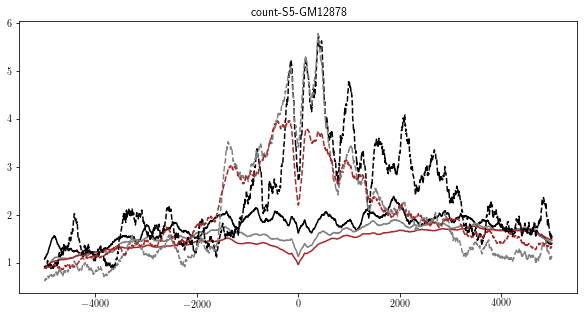

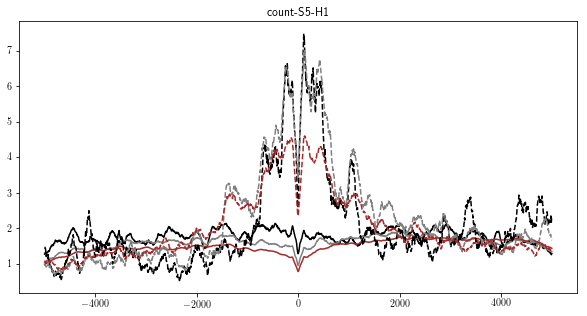

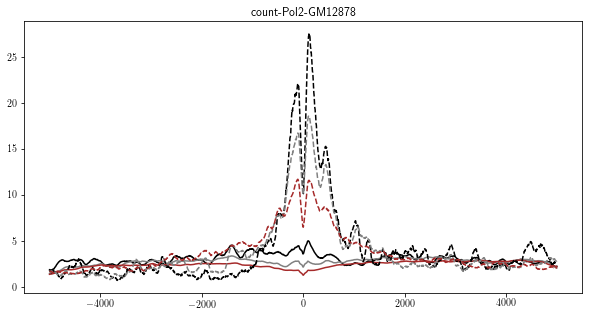

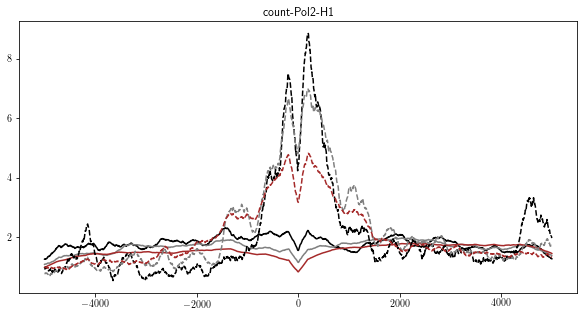

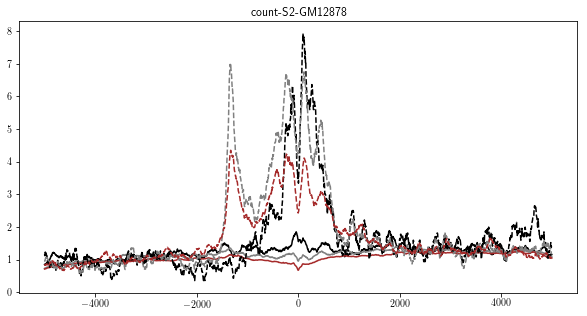

In [11]:
cols = ["dist","count-S5-H1","5p1","3p1", \
                   "count-S5-GM12878","5p2","3p2", \
                   "count-Pol2-H1", "5p3","3p3", \
                   "count-Pol2-GM12878", "5p4","3p4", \
                   "count-S2-GM12878", "5p5", "3p5", \
                   "count-dnase-GM12878", "5p6", "3p6", \
                   "count-mnase-GM12878", "5p7","3p7"]
pol2_all = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-pol2-all_strs.txt_tss", sep="\t")
pol2_all.columns = cols

pol2_causal = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-pol2-all_causal_estrs_tss.txt", sep="\t")
pol2_causal.columns = cols

pol2_estr = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-pol2-all_estrs_tss.txt", sep="\t")
pol2_estr.columns = cols

pol2_causal_g4 = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-pol2-all_causal_g4.txt", sep="\t")
pol2_causal_g4.columns = cols

pol2_estr_g4 = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-pol2-all_estrs_g4.txt", sep="\t")
pol2_estr_g4.columns = cols

pol2_all_g4 = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-pol2-all_strs_g4.txt", sep="\t")
pol2_all_g4.columns = cols

for usecol in ["count-S5-GM12878", "count-S5-H1", \
           "count-Pol2-GM12878", "count-Pol2-H1", "count-S2-GM12878"]:
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    ax = fig.add_subplot(111)
    ax.plot(pol2_causal["dist"], pol2_causal[usecol], color="black")
    ax.plot(pol2_estr["dist"], pol2_estr[usecol], color="gray")
    ax.plot(pol2_all["dist"], pol2_all[usecol], color="brown")
    
    ax.plot(pol2_causal_g4["dist"], pol2_causal_g4[usecol], color="black", linestyle="dashed")
    ax.plot(pol2_estr_g4["dist"], pol2_estr_g4[usecol], color="gray", linestyle="dashed")
    ax.plot(pol2_all_g4["dist"], pol2_all_g4[usecol], color="brown", linestyle="dashed")
    ax.set_title(usecol)
    fig.savefig(os.path.join(RESULTSDIR, "%s_G4_%s.pdf"%(FIGPREFIX, usecol)))

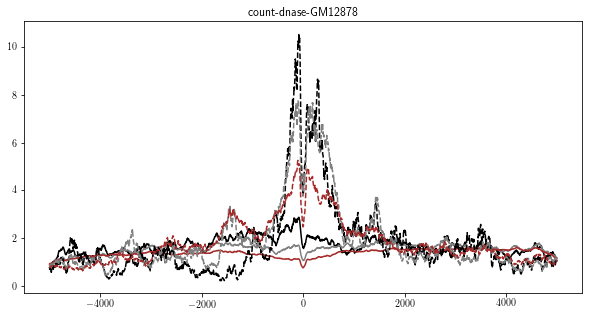

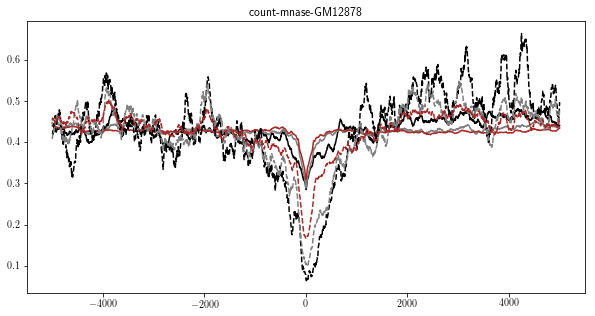

In [13]:
for usecol in ["count-dnase-GM12878"]:
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    ax = fig.add_subplot(111)
    ax.plot(pol2_causal["dist"], pol2_causal[usecol], color="black")
    ax.plot(pol2_estr["dist"], pol2_estr[usecol], color="gray")
    ax.plot(pol2_all["dist"], pol2_all[usecol], color="brown")
    
    ax.plot(pol2_causal_g4["dist"], pol2_causal_g4[usecol], color="black", linestyle="dashed")
    ax.plot(pol2_estr_g4["dist"], pol2_estr_g4[usecol], color="gray", linestyle="dashed")
    ax.plot(pol2_all_g4["dist"], pol2_all_g4[usecol], color="brown", linestyle="dashed")
    ax.set_title(usecol)

for usecol in ["count-mnase-GM12878"]:
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    ax = fig.add_subplot(111)
    ax.plot(pol2_causal["dist"], pol2_causal[usecol], color="black")
    ax.plot(pol2_estr["dist"], pol2_estr[usecol], color="gray")
    ax.plot(pol2_all["dist"], pol2_all[usecol], color="brown")
    
    ax.plot(pol2_causal_g4["dist"], pol2_causal_g4[usecol], color="black", linestyle="dashed")
    ax.plot(pol2_estr_g4["dist"], pol2_estr_g4[usecol], color="gray", linestyle="dashed")
    ax.plot(pol2_all_g4["dist"], pol2_all_g4[usecol], color="brown", linestyle="dashed")
    ax.set_title(usecol)


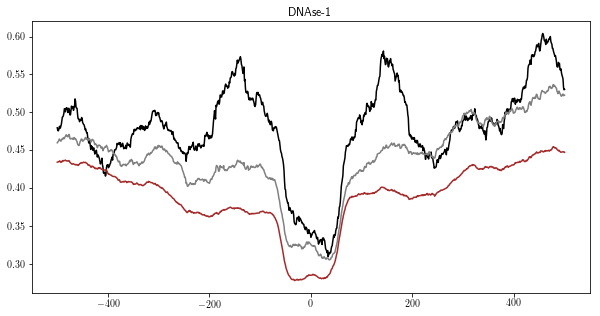

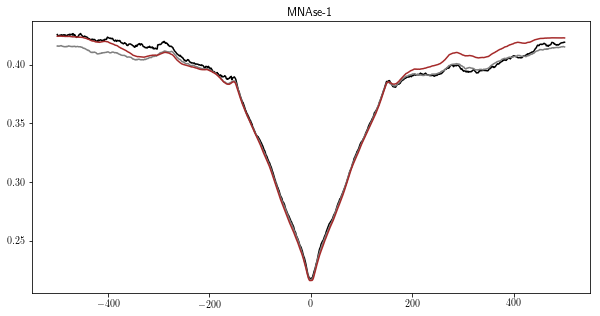

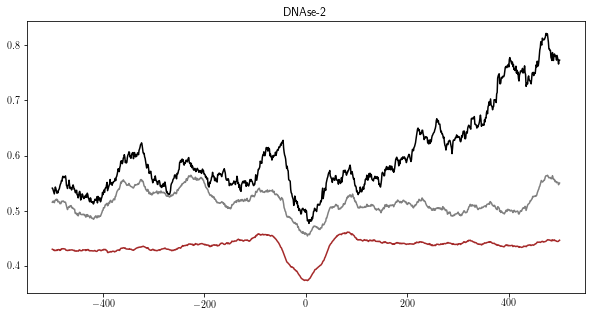

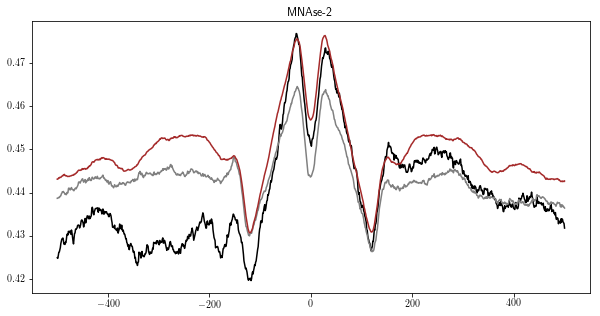

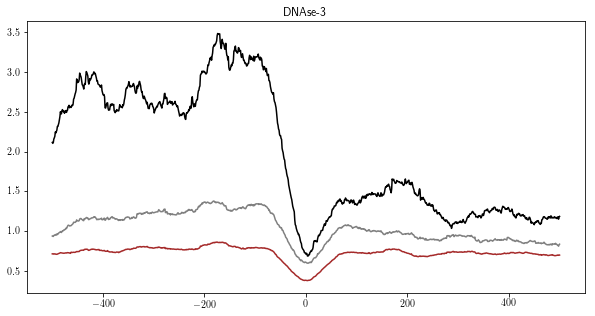

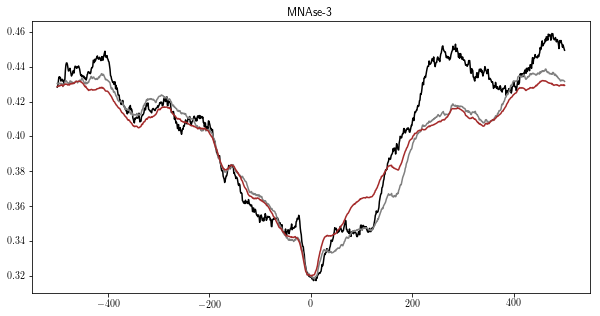

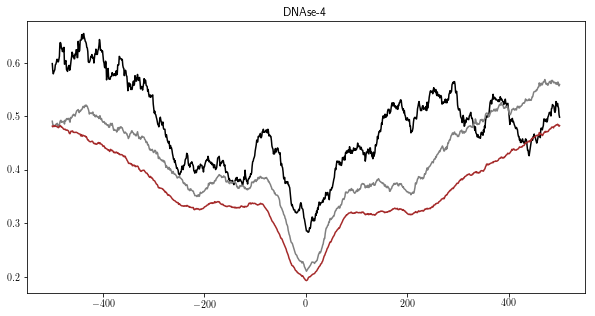

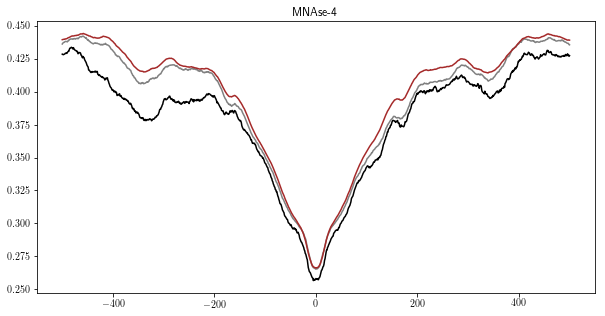

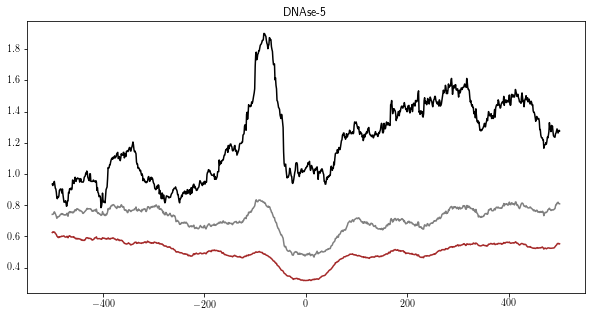

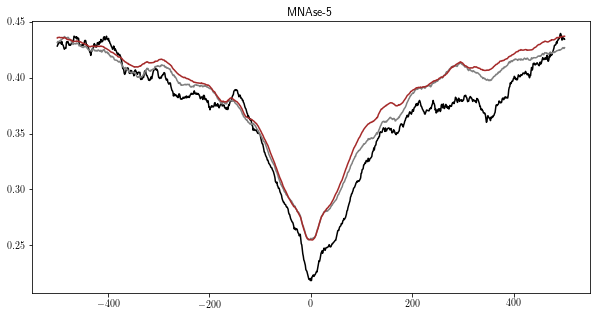

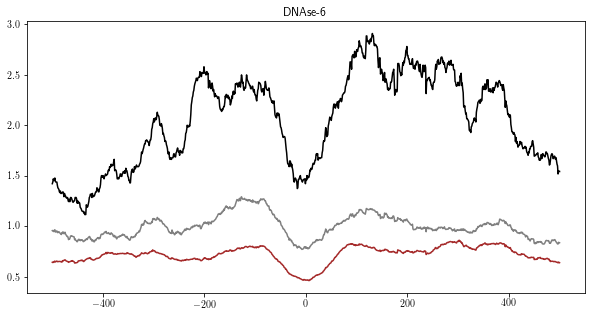

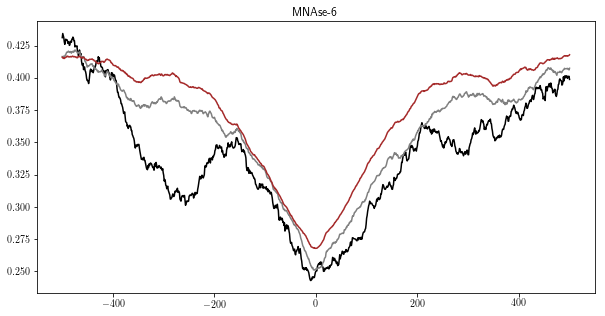

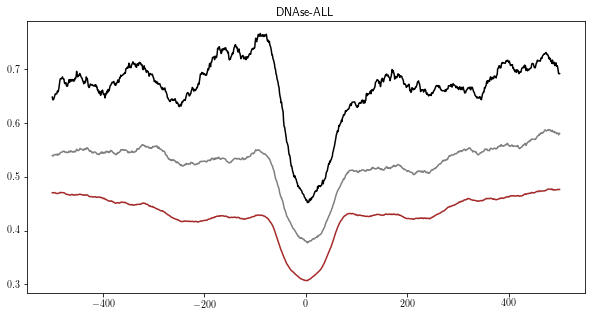

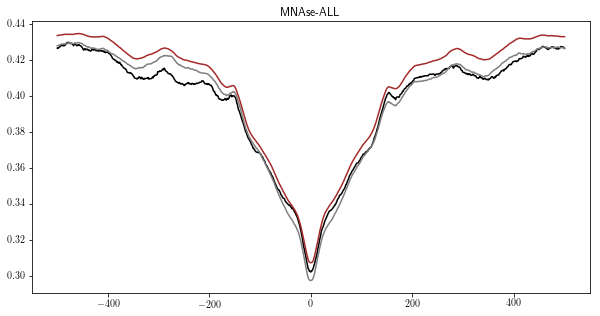

In [29]:
cols = ["dist","count-dnase-GM12878","5p1","3p1",
       "count-mnase-GM12878", "5p1","3p2"]

for period in list(range(1, 7))+["ALL"]:
    if period != "ALL":
        mn_all = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_strs_%s.txt"%period, sep="\t")
        mn_causal = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_causal_%s.txt"%period, sep="\t")
        mn_estr = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_estr_%s.txt"%period, sep="\t")
    else:
        mn_all = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_strs.txt", sep="\t")
        mn_causal = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_causal_estrs.txt", sep="\t")
        mn_estr = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_estrs.txt", sep="\t")

    mn_all.columns = cols
    mn_causal.columns = cols
    mn_estr.columns = cols
    for usecol in ["count-dnase-GM12878"]:
        fig = plt.figure()
        fig.set_size_inches((10, 5))
        ax = fig.add_subplot(111)
        ax.plot(mn_causal["dist"], mn_causal[usecol], color="black")
        ax.plot(mn_estr["dist"], mn_estr[usecol], color="gray")
        ax.plot(mn_all["dist"], mn_all[usecol], color="brown")
        ax.set_title("DNAse-%s"%period)
    for usecol in ["count-mnase-GM12878"]:
        fig = plt.figure()
        fig.set_size_inches((10, 5))
        ax = fig.add_subplot(111)
        ax.plot(mn_causal["dist"], mn_causal[usecol], color="black")
        ax.plot(mn_estr["dist"], mn_estr[usecol], color="gray")
        ax.plot(mn_all["dist"], mn_all[usecol], color="brown")
        ax.set_title("MNAse-%s"%period)